#### Home Assigment 2, CMPE 260, Spring 2022, SJSU.

**Question 1 (18 points of 33): MDP - exact solution in the tabular case**. In this question you will solve MDP by **Value Iteration** and **Policy Iteration** algorithms with a known dynamics and reward $T$ and $R$, respectively. 

## Theoretical part (3 points)
Show that the expected accumulated reward with the discounting factor $0\le \gamma < 1$ and constants rewards $\forall t  \; r_t=r$
$$V^{\pi}(s) = E_{p(\tau\mid s)}\Bigl[\sum_{t=1}^{\infty}\gamma^{t-1}r_t\Bigr]$$
is equal to $$\frac{r}{1 − γ}.$$

In [1]:
# 1. First we can extract r_t

#(V^pi)[s] = r_t * E_p(tau|s) * [sum[t=1 -> inf] (y^t-1)]


# 2. Since we now have a simple geometric series, we can re-represent it as the following:

#[sum[n=1 -> inf] b] = (x/1-y), |y| < 1

#b = (x*y^0) + (x*y^1) + (x*y^2) + ... + (x*y^n)


# 3. Simple algebra to fix r's representation results in the following:

#(V^pi)[s] = (x^0/1-y) * r_t

#(V^pi)[s] = (r/1-y)

## Practical part (15 points)

import the necessary libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
%%javascript 
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [4]:
plt.rcParams["figure.figsize"] = (15,15) # Added For Visual Ease

As per the problem definition, we define the following variables:

In [5]:
GRID_SIZE = 15

START = (0, 0)
GOAL = (14, 14)

# Action Space
A = [
    (-1, 0),    # 'up'
    (1, 0),     # 'down'
    (0, -1),    # 'left'
    (0, 1),     # 'right'
    (0, 0)      # 'stay'
]

# State Space
S = np.zeros((GRID_SIZE, GRID_SIZE))

# Noise
ALPHA = [0.2, 0.8]

Define maze walls. 0 - no wall, 1 - horizontal wall no the bottom of the cell, 2 - vertical wall on the right of the cell

In [6]:
# horizontal walls
S[3, 0:12] = 1
S[5, 10: ] = 1
S[8, 3:12] = 1
S[11, 4: ] = 1

# vertical walls
S[8:12, 2] = 2

# goal state
S[GOAL]    = 3

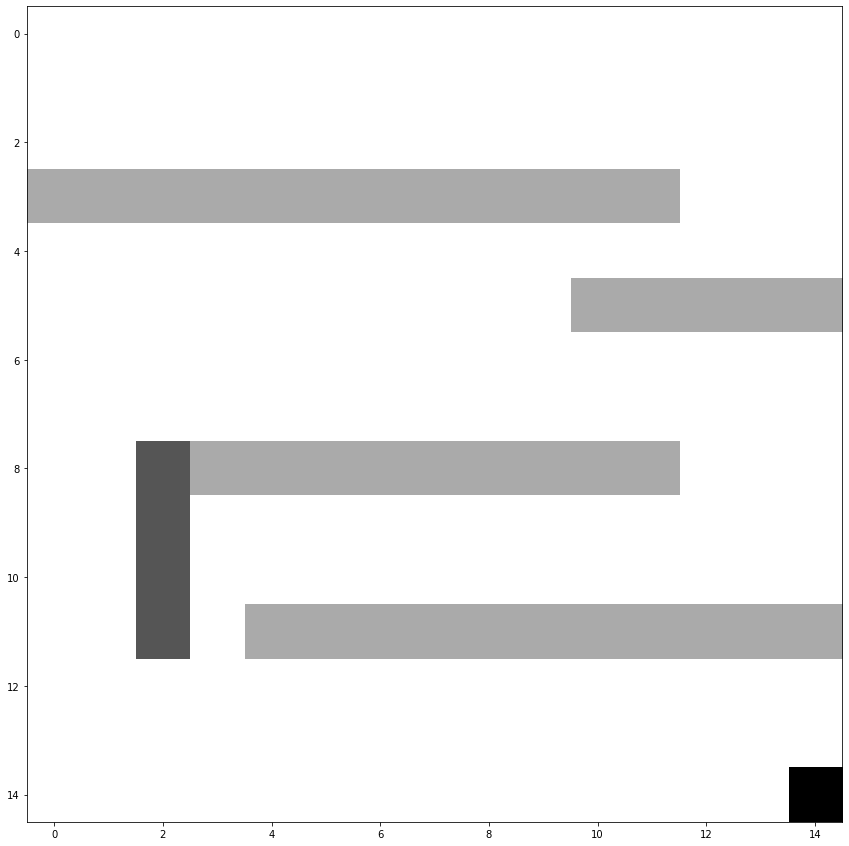

In [7]:
plt.imshow(S, cmap='binary')

In [8]:
S[7:10, 12] = 2# Extended 2nd wall from top

Visualize the maze

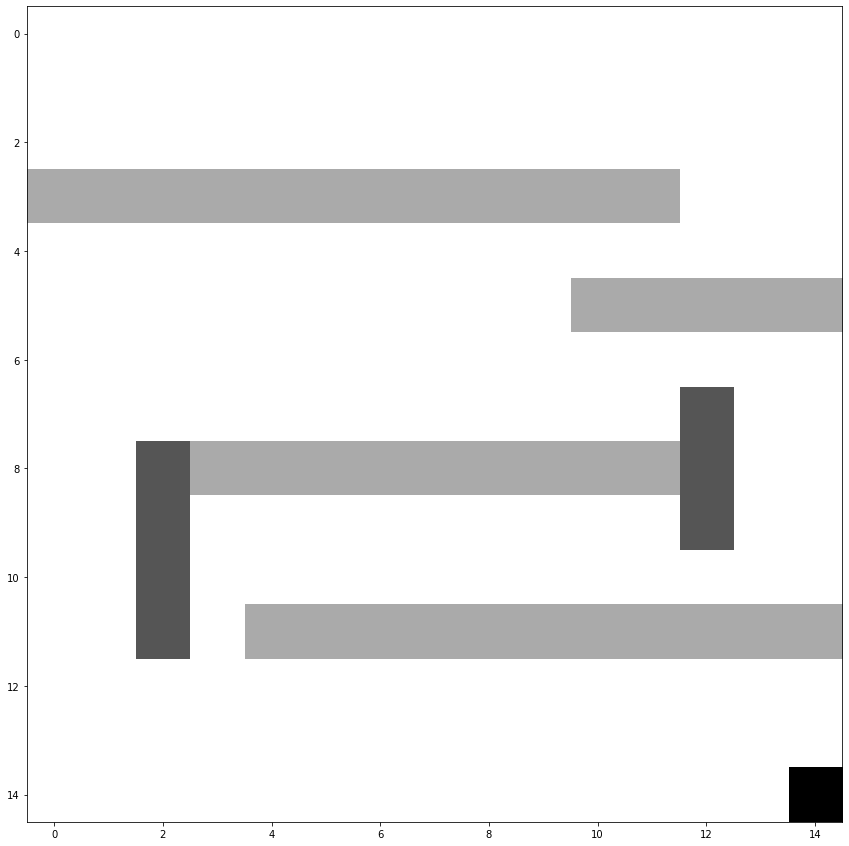

In [9]:
plt.imshow(S, cmap='binary')

We will define a utility function s_next_calc which computes the index of the next state given current state and action.

In [10]:
def s_next_calc(s, a):
    '''This function returns the agent's next state given action
    and current state (assuming the action succeeds).
    : param s: Current position of the agent
    : param a: action taken by the agent
    : returns: New state coordinates in the grid
    '''

    return (s[0] + A[a][0], s[1] + A[a][1])

A Utility function to check if the action at current state leads to a collision with a wall.

In [11]:
def hit_wall(curr, action):
    '''This function checks if the agent hits any walls.
    : param curr: Current position of the agent
    : param action: Chosen action by the agent
    : returns: True/False Binary value to indicate if agent hits a wall
    '''
    s_new = (
        curr[0] + A[action][0],
        curr[1] + A[action][1]
    )

    # Check for grid boundaries
    if min(s_new) < 0 or max(s_new) > GRID_SIZE-1:
        return True

    # Check walls
    # 0: 'up':   (-1,  0),
    # 1: 'down': ( 1,  0),
    # 2: 'left': ( 0, -1),
    # 3: 'right':( 0,  1),
    # 4: 'stay': ( 0,  0)
    if (S[curr]==1 and action==1) \
        or (S[curr]==2 and action==3) \
        or (S[s_new]==1 and action==0)\
        or (S[s_new]==2 and action==2):
        return True

    return False

Reward function.

In [12]:
def R(s, a):
    '''Reward function
    : param s: Current state of the agent
    : param a: Action the agent takes at the current state
    : returns: Reward for the action at current state
    '''
    if s == GOAL:
        return 0
    elif hit_wall(s, a):
        return -10000
    else:
        return -1

Calculate the transition probabilities to state s_next from current state s upon action a.

In [13]:
def Pr(s_next, s, a, alpha):
    '''This function returns probabilities for each action at agent's
    current state.
    :param s: Current state of the agent
    :param a: Action the agent takes at the current state
    :param alpha: Probability of the agent to take a random action instead of the action a
    :returns : Transition probability for the action at current state
    '''
    # can't move once reached the GOAL
    if s == GOAL:
        if s_next == s:
            return 1
        else:
            return 0

    # If wall hit, next state is current state
    if hit_wall(s, a):
        # Illegal action with s = s'
        if s_next == s:
            return 1
        # Illegal action with s != s'
        else:
            return 0

    # Legal action with adjacent s and s'
    if s_next == s_next_calc(s, a):
        return 1 - alpha
    else:
        # Agent moves to another adjacent state instead of s' due to noise in a
        # Generate all other neighbors of s by applying actions other than a
        other_s_next = [s_next_calc(s, i)
                    for i in range(len(A)) if i is not a]
        if s_next in other_s_next:
            return alpha/4
    return 0

## Policy Iteration

In policy iteration, we define three functions:

* policy_evaluation
* policy_improvement
* policy_iteration

refer to slides starting from 151 for policy iteration and value iteration.

In [14]:
# I found difficulty representing the next state given a policy. i.e. (V[s'])
# I used a discount factor of .95 so that I could see convergence. 

# Policy Iteration EQ:

    # Policy Evaluation

        # V_k+1[s] = R(s,a) + discount * sum(prob(s'|s,policy[s]) * V[s'])

    # Policy Improvement
    
        # policy[s] = argmax(R(s,a) + discount * sum(prob(s'|s,a) * V[s']))

In [15]:
def policy_evaluation(policy, S, Pr, alpha, ctr):
    V = np.zeros((GRID_SIZE, GRID_SIZE))
    for _ in range(ctr):
        for s, _ in np.ndenumerate(S):
            a = policy[s]
            V[s] =  R(s,a) + (.95 * sum(Pr(step, s, a, alpha) * 
                                          ((V[step])) 
                                          for step, _ in np.ndenumerate(S))) # Change Here
    return V

In [16]:
def policy_improvement(V, S, A, Pr, alpha):
    policy = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
    for s, _ in np.ndenumerate(S):
        Q = np.zeros(len(A))
        for a in range(len(A)):
            Q[a] = R(s,a) + (.95 * sum(Pr(step, s, a, alpha) * 
                                          ((V[step])) 
                                          for step, _ in np.ndenumerate(S)))  # Change Here 
            policy[s] = np.argmax(Q) # Change Here
    return policy

In [17]:
def policy_iteration(S, A, Pr, alpha, n_iter, n_eval, plot=None):
    """
    :param list S: set of states
    :param list A: set of actions
    :param function Pr: transition function
    :param float alpha: discount factor 
    :param int n_iter: number of iterations
    :param int n_eval: number of evaluations
    :param plot: list of iteration numbers to plot
    """
    
    plt.ion()
    policy = np.random.randint(0, len(A), (GRID_SIZE, GRID_SIZE))
    for _ in range(n_iter):
        V = policy_evaluation(policy, S, Pr, alpha, n_eval) # Confident Change Here
        policy = policy_improvement(V, S, A, Pr, alpha) # Confident Change Here
        # plot current value and optimal policy
        if plot and _+1 in plot:
            plot_value_grid(V, policy, msg='Policy iteration, alpha = {}, iteration = {}/{}'.format(alpha, _+1, n_iter))
    return V, policy

## Value Iteration

We use the following function for value iteration. See slides starting from 161.

In [18]:
# I found difficulty representing the next state. i.e. (V[s'])


# Value Iteration EQ:

    # V_k+1[s] = max(R(s,a) + discount * sum(prob(s',r|s,a)) * (R(s,a) + discount * V_k(s'))

In [19]:
def value_iteration(S, A, Pr, alpha, ctr=100, plot=None):
    """
    :param list S: set of states
    :param list A: set of actions
    :param function Pr: transition function
    :param float alpha: noise parameter
    """
    plt.ion()

    # I used a discount factor of .95.
    
    V = np.zeros((GRID_SIZE, GRID_SIZE))
    optimal_policy = np.random.randint(0, len(A), (GRID_SIZE, GRID_SIZE), dtype=int)
    for x in range(ctr):
        for s,_ in np.ndenumerate(S):
            Q = np.zeros(len(A))
            for a in range(len(A)):
                Q[a] = R(s,a) + .95 * sum(Pr(step, s, a, alpha) * 
                                          (R(s,a) + .95 * (V[step])) 
                                          for step, _ in np.ndenumerate(S))  # Confident Changed Here
            V[s] = max(Q) # Change Here
            optimal_policy[s] = np.argmax(Q) # Change Here

        # plot current value and optimal policy
        if plot and x+1 in plot:
            plot_value_grid(V, optimal_policy, msg='Value iteration, alpha = {}, iteration = {}'.format(alpha, x+1))
            plt.pause(0.1)
    return V, optimal_policy

We will use the following utility function to plot the grid with values from V.

In [20]:
def plot_value_grid(V, policy, msg=""):
    plt.figure(figsize=(15, 15), tight_layout=True)
    plt.title(msg)
    plt.imshow(V)
    quiver_action_dict = [
            [1, 0],
            [-1, 0],
            [0, -1],
            [0, 1],
            [0, 0]
    ]
    for k, a in np.ndenumerate(policy):
        plt.quiver(k[1], k[0],
                  quiver_action_dict[a][1], quiver_action_dict[a][0])
    plt.show()

## Tasks
### A. Find the optimal solution by two methods for $\alpha$ = 0.

#### I. Policy Iteration 

We are using iterative policy evaluation. Let's set the number of iterations for policy evaluation (k_max) as 50 and the number of iterations for policy iteration as 50 (it will take some time to run)

C:\Users\GIGA\anaconda3\lib\site-packages\matplotlib\quiver.py:689: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\GIGA\anaconda3\lib\site-packages\matplotlib\quiver.py:689: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


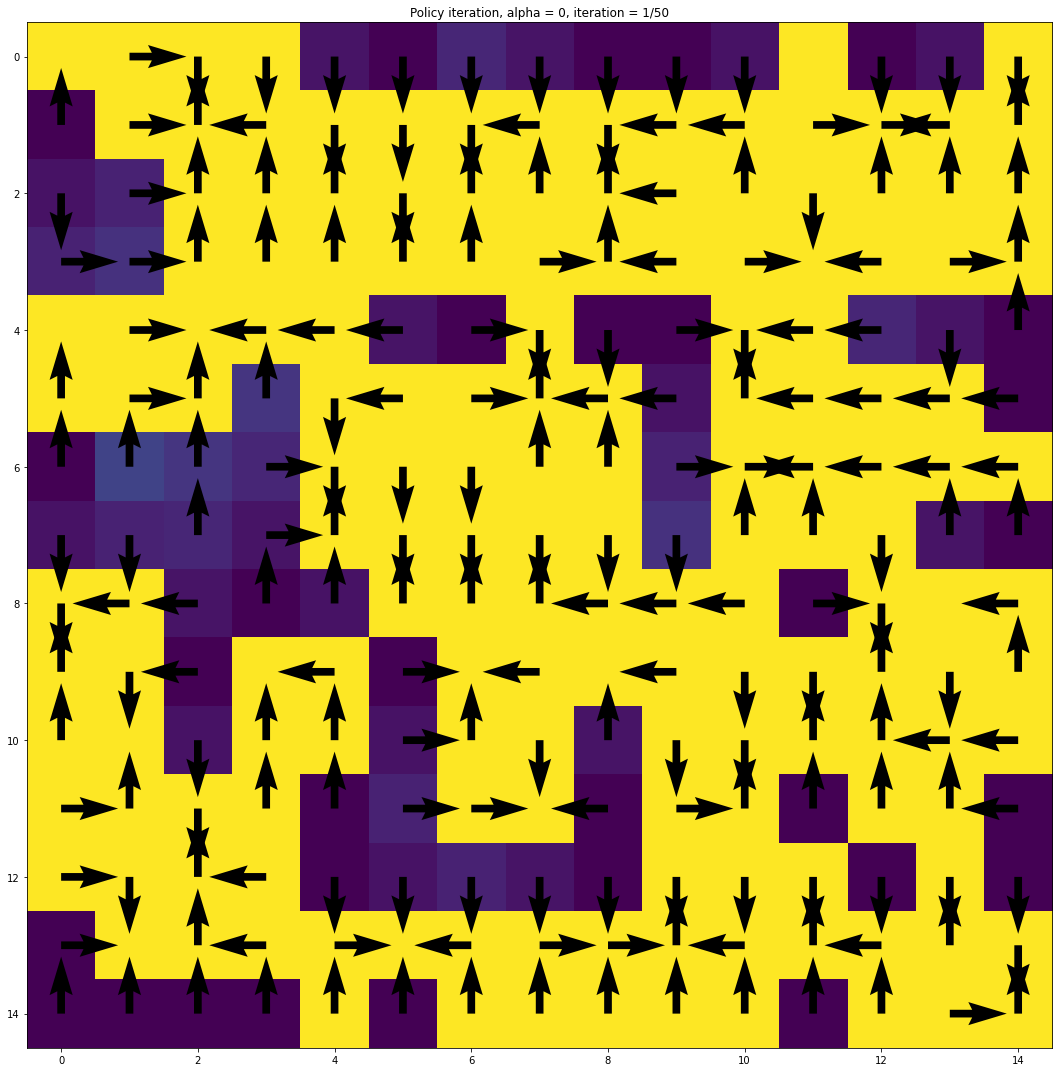

KeyboardInterrupt: 

In [21]:
n_pol_iter = 50
n_pol_eval = 50
val2, pol2 = policy_iteration(S, A, Pr, alpha=0, n_iter=n_pol_iter, n_eval=n_pol_eval, plot=[1, 10, 20, 30, 40, 50])

#### II. Value Iteration

Run for 100 iterations and no noise
Plot the value function and the optimal policy every 20 iterations

In [ ]:
n_val_iter=100
val1, pol1 = value_iteration(S, A, Pr, alpha=0, ctr=n_val_iter, plot=[1, 20, 40, 60, 80, 100])

Let's visualize these results

In [ ]:
# Plot for policy iteration alpha = 0, k_max = 100, run for 100 iterations
plot_value_grid(val2, pol2, msg='Policy Iteration, {} iterations, {} evaluations'.format(n_pol_iter, n_pol_eval))
# Plot for value iteration alpha = 0, 100 iterations
plot_value_grid(val1, pol1, msg='Value Iteration, {} iterations'.format(n_val_iter))

### B. Repeat Value and Policy iteration for 10, 20 and 100 iterations with $\alpha \in \{0.2, 0.8\}$

#### I. Policy Iteration 

In [ ]:

for idx1, alpha in enumerate(ALPHA):
    # for idx2, i in enumerate():
    val, pol = policy_iteration(S, A, Pr, alpha=alpha,
                                n_iter=50, n_eval=100, plot=[1,2,3,4,5,6,7,10, 20, 50])

#### II. Value Iteration

In [ ]:
for idx1, alpha in enumerate(ALPHA):
    val, pol = value_iteration(S, A, Pr, alpha = alpha, ctr=100, plot=[10, 20, 100])

**Summarize briefly insights and your observations in Question 1.** 